# Imports

In [1]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn

N_CLASSES = 3

wandb.login()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'
device

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kazadaevms. Use `wandb login --relogin` to force relogin


device(type='cuda', index=0)

# Train Loop

[[0.75], [0.6666666666666666], [0.6666666666666666]]

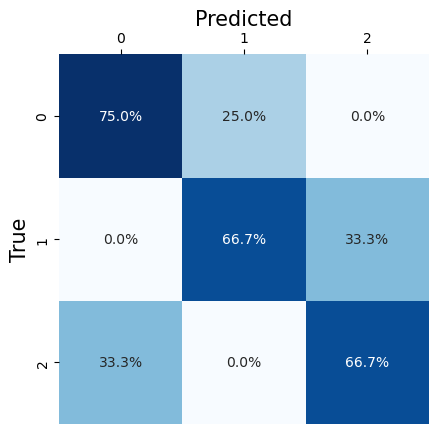

In [2]:
from sklearn.metrics import confusion_matrix


def get_confusion_matrix(predicted_labels, true_labels):
    error_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')
    return pd.DataFrame(error_matrix, index=[f'true_{i}' for i in range(N_CLASSES)], columns=[f'pred_{i}' for i in range(N_CLASSES)])


def plot_confusion_matrix(matrix: pd.DataFrame):
    FONT_SIZE = 15
    ax = sns.heatmap(matrix, annot=True, fmt=".1%", cmap="Blues", cbar=False, square=True)
    ax.set_xlabel('Predicted', fontsize=FONT_SIZE)
    ax.set_ylabel('True', fontsize=FONT_SIZE)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.xaxis.set_tick_params(labeltop=True)  # Set the x-axis labels on top
    ax.yaxis.set_ticklabels(list(range(N_CLASSES)))
    ax.xaxis.set_ticklabels(list(range(N_CLASSES)), ha="center")


def get_accuracy_by_classes(matrices: list[pd.DataFrame]) -> list[list[float]]:
    result = []
    for i in range(N_CLASSES):
        accuracies = [matrix.iloc[i, i] for matrix in matrices]
        result.append(accuracies)
    return result


tmp = get_confusion_matrix(np.array([0, 1, 2, 1, 0, 2, 0, 1, 2, 0]), np.array([0, 1, 2, 1, 0, 1, 2, 0, 2, 0]))
plot_confusion_matrix(tmp)
get_accuracy_by_classes([tmp])

In [3]:
from timeit import default_timer as timer
from IPython.display import clear_output
from tqdm.notebook import tqdm


def train_loop(model, optimizer, criterion, train_loader) -> tuple:
    train_loss, train_accuracy = 0.0, 0.0
    predicted_labels = []
    true_labels = []

    model.train()

    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # images: batch_size x num_channels x height x width
        logits = model(images)
        # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # save predictions and true labels
        predicted_labels.append(logits.argmax(dim=1).detach().cpu())
        true_labels.append(labels.cpu())

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.detach().argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)

    predicted_labels = torch.concat(predicted_labels)
    true_labels = torch.concat(true_labels)
    matrix = get_confusion_matrix(predicted_labels, true_labels)

    return train_loss, train_accuracy, matrix


@torch.no_grad()
def val_loop(model, criterion, val_loader) -> tuple:
    val_loss, val_accuracy = 0.0, 0.0
    predicted_labels = []
    true_labels = []

    model.eval()

    for images, labels in tqdm(val_loader, desc='Validating'):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(images)
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)

        # save predictions and true labels
        predicted_labels.append(logits.argmax(dim=1).cpu())
        true_labels.append(labels.cpu())

        val_loss += loss.item() * images.shape[0]
        val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)

    predicted_labels = torch.concat(predicted_labels)
    true_labels = torch.concat(true_labels)
    matrix = get_confusion_matrix(predicted_labels, true_labels)

    return val_loss, val_accuracy, matrix


def plot_losses(lrs, train_losses, val_losses, train_accuracies, val_accuracies, confusion_matrices_train: pd.DataFrame, confusion_matrices_val: pd.DataFrame):
    clear_output()
    assert len(train_losses) == len(val_losses) == len(train_accuracies) == len(val_accuracies)

    # plot losses
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    x_epochs = list(range(1, len(train_losses) + 1))
    axs[0].plot(x_epochs, train_losses, label='train')
    axs[0].plot(x_epochs, val_losses, label='val')
    axs[0].set_xticks(x_epochs, labels=x_epochs)
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='val')
    axs[1].set_xticks(x_epochs, labels=x_epochs)
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()
    plt.show()

    # plot accuracy for each class
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    for i, (train_val_label, confusion_matrices) in enumerate(zip(['Train', 'Val'], [confusion_matrices_train, confusion_matrices_val])):
        axs[i].set_title(train_val_label)
        accuracies_by_classes = get_accuracy_by_classes(confusion_matrices)
        for j in range(N_CLASSES):
            axs[i].plot(x_epochs, accuracies_by_classes[j], label=f'{j} class')
        axs[i].set_xticks(x_epochs, labels=x_epochs)
        axs[i].set_ylabel('accuracy')
        axs[i].legend(loc='upper left')
    plt.show()

    # plot confusion matrices
    FONT_SIZE = 15
    plt.subplots(1, 2, figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.title('Confusion matrix train', fontsize=FONT_SIZE)
    plot_confusion_matrix(confusion_matrices_train[-1])

    plt.subplot(1, 2, 2)
    plt.title('Confusion matrix val',  fontsize=FONT_SIZE)
    plot_confusion_matrix(confusion_matrices_val[-1])
    plt.show()


def train_nn(model, optimizer, criterion, scheduler, train_loader, val_loader, n_epochs: int, log_wandb: bool):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    confusion_matrices_train, confusion_matrices_val = [], []
    lrs = []

    for epoch in range(1, n_epochs + 1):
        # Train
        start_time = timer()
        train_loss, train_accuracy, confusion_matrix_train = train_loop(model, optimizer, criterion, train_loader)
        confusion_matrices_train.append(confusion_matrix_train)
        train_time = timer() - start_time
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        # Validation
        start_time = timer()
        val_loss, val_accuracy, confusion_matrix_val = val_loop(model, criterion, val_loader)
        confusion_matrices_val.append(confusion_matrix_val)
        val_time = timer() - start_time
        val_losses += [val_loss]
        val_accuracies += [val_accuracy]

        # Log lr used on current epoch
        lr = next(iter(optimizer.param_groups))['lr']
        lrs.append(lr)

        # Scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Log record
        record = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'lr': lr,
            'train_time': train_time,
            'val_time': val_time,
        }
        if log_wandb:
            wandb.log(record)

        # Plot
        plot_losses(lrs, train_losses, val_losses, train_accuracies, val_accuracies, confusion_matrices_train, confusion_matrices_val)
    if log_wandb:
        wandb.finish()

# Data

In [4]:
import torchvision.transforms as T
from loader import get_dataloaders

# make dataloaders
TARGET_SIZE = 128
transform = T.Compose([T.ToTensor(), T.Resize((TARGET_SIZE, TARGET_SIZE))])
train_loader, val_loader = get_dataloaders('../data', train_transform=transform, test_transform=transform, transform_name=f'Resize({TARGET_SIZE}, {TARGET_SIZE})')

# show dataset size
TRAIN_SIZE = len(train_loader.dataset)
VAL_SIZE = len(val_loader.dataset)
print(f'Train size: {TRAIN_SIZE}. Val size: {VAL_SIZE}. Val ratio: {VAL_SIZE / (TRAIN_SIZE + VAL_SIZE) * 100:.2f}%')

Train size: 6777. Val size: 2261. Val ratio: 25.02%


# Model

In [5]:
class LeNet32(nn.Module):
    IMAGE_CHANNELS = 3

    def __init__(self):
        assert TARGET_SIZE == 32
        super().__init__()
        self.encoder = nn.Sequential(  # 32 x 32
            nn.Conv2d(in_channels=self.IMAGE_CHANNELS, out_channels=6, kernel_size=5),  # 28 x 28
            nn.Tanh(),
            nn.MaxPool2d(2),  # 14 x 14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),  # 10 x 10
            nn.Tanh(),
            nn.MaxPool2d(2),  # 5 x 5
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)  # 1 x 1
        )

        self.head = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=N_CLASSES)
        )

    def forward(self, x):
        # x: B x 1 x TARGET_SIZE x TARGET_SIZE
        out = self.encoder(x)
        # out: B x 120 x 1 x 1
        out = out.squeeze(-1).squeeze(-1)
        # out: B x 120
        out = self.head(out)
        # out: B x 10
        return out


class LeNet128(nn.Module):
    IMAGE_CHANNELS = 3

    def __init__(self):
        assert TARGET_SIZE == 128
        super().__init__()
        self.encoder = nn.Sequential(  # 128 x 128
            nn.Conv2d(in_channels=self.IMAGE_CHANNELS, out_channels=3, kernel_size=5),  # 124 x 124
            nn.Tanh(),
            nn.MaxPool2d(2),  # 62 x 62
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),  # 58 x 58
            nn.Tanh(),
            nn.MaxPool2d(2),  # 29 x 29
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),  # 24 x 24
            nn.Tanh(),
            nn.MaxPool2d(2),  # 12 x 12
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5),  # 8 x 8
            nn.Tanh(),
            nn.MaxPool2d(2),  # 4 x 4
            nn.Conv2d(in_channels=64, out_channels=120, kernel_size=4),  # 1 x 1
        )

        self.head = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=N_CLASSES)
        )

    def forward(self, x):
        # x: B x 1 x TARGET_SIZE x TARGET_SIZE
        out = self.encoder(x)
        # out: B x 120 x 1 x 1
        out = out.squeeze(-1).squeeze(-1)
        # out: B x 120
        out = self.head(out)
        # out: B x 10
        return out


with torch.no_grad():
    result = LeNet128()(next(iter(train_loader))[0])
    print(result.size())

torch.Size([64, 3])


# Actual training

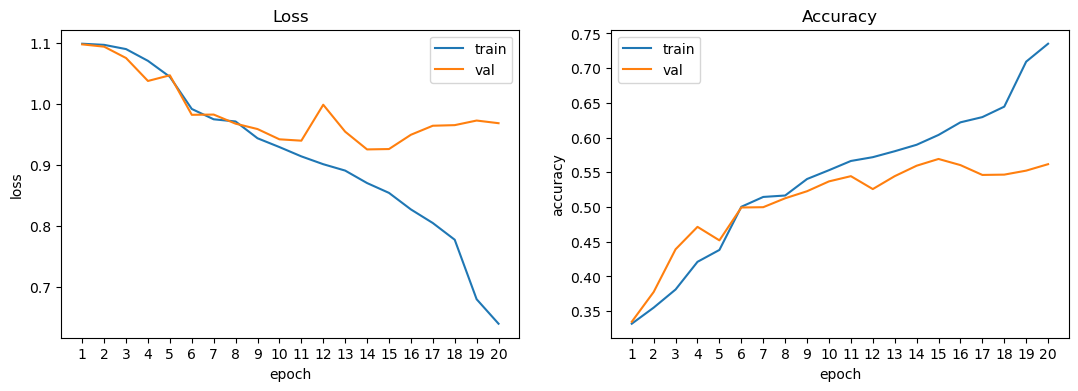

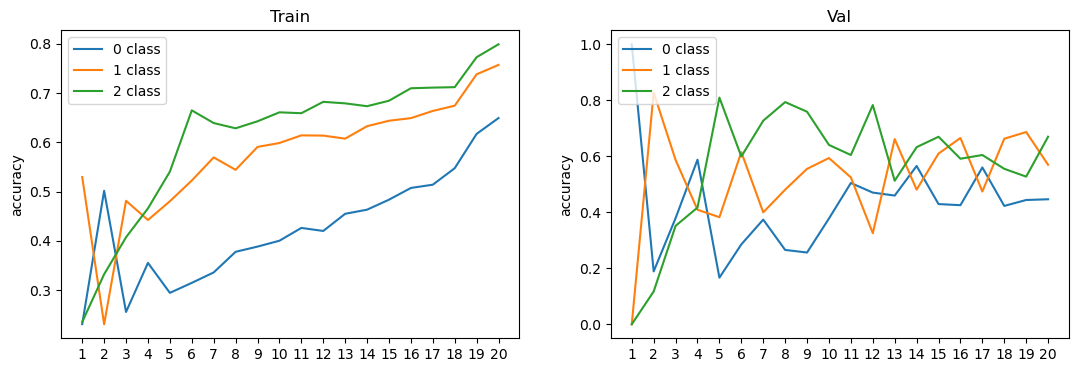

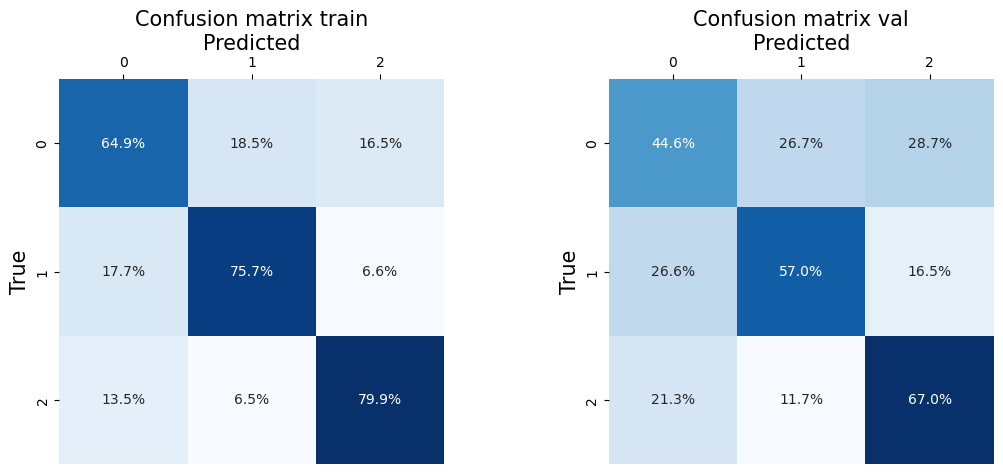

Success


In [6]:
LOG_WANDB = False
N_EPOCHS = 20

FACTOR = 0.3
PATIENCE = 3

model = LeNet128().to(device)

LR = 1e-2
MOMENTUM = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE)
criterion = nn.CrossEntropyLoss()

experiment_name = f'LeNet128'
notes = f'''
Optimizer: SGD({LR=}, {MOMENTUM=})
Scheduler: ReduceLROnPlateau({FACTOR=}, {PATIENCE=})
'''

if LOG_WANDB:
    wandb.init(
        project='VK Hackathon',
        name=experiment_name,
        notes=notes
    )

try:
    torch.manual_seed(0)
    train_nn(model, optimizer, criterion, scheduler, train_loader=train_loader, val_loader=val_loader, n_epochs=N_EPOCHS, log_wandb=LOG_WANDB)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
    if LOG_WANDB:
        wandb.finish()

print('Success')